# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn"))

from data import isic_archive_load
from auc_metric import calculate_auc
from gradcam import display_gradcam, make_gradcam_heatmap, get_img_array
from fractal.perc import FractalImage

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
tf.get_logger().setLevel('ERROR')

### Model description

- Model architecture: XCeption
- Fractal module used: with Percolation 
- Number of layers tuned: 2

### Load the ISIC Archive dataset

In [4]:
training_set, testing_set, validation_set = isic_archive_load()

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/data/isic_archive.py:20: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


### Model definition and callbacks

In [5]:
class LesionClassifier(tf.keras.Model):
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    
    def __init__(self, class_number):
        super(LesionClassifier, self).__init__()
        
        self.fractal_image = FractalImage()
        self.resize = tf.keras.layers.Resizing(
            width=self.TARGET_WIDTH,
            height=self.TARGET_HEIGHT
        )
        self.rescale = tf.keras.layers.Rescaling(scale=1./255)
        
        self.o_model = tf.keras.applications.xception.Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.o_model.layers:
            if layer.name in ['block14_sepconv1','block14_sepconv2']:
                layer.trainable = True
            else:
                layer.trainable = False 
        
        self.f_model = tf.keras.applications.xception.Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.f_model.layers:
            if layer.name in ['block14_sepconv1','block14_sepconv2']:
                layer.trainable = True
            else:
                layer.trainable = False   
        
        self.concatenate = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)
        
        f_outputs = self.fractal_image(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)
        
        outputs = self.concatenate([f_outputs, o_outputs])
        outputs = self.dense(outputs)
        
        return outputs

In [6]:
checkpoint_path = 'checkpoints/model.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [7]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

### Training

In [8]:
strategy = tf.distribute.MirroredStrategy()

In [9]:
with strategy.scope():
    model = LesionClassifier(class_number=len(training_set.class_indices))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=30,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ]
)

Epoch 1/30
947/947 [==============================] - ETA: 0s - loss: 1.2073 - accuracy: 0.6668
Epoch 1: val_loss improved from inf to 1.17822, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6641s 7s/step - loss: 1.2073 - accuracy: 0.6668 - val_loss: 1.1782 - val_accuracy: 0.6653
Epoch 2/30
947/947 [==============================] - ETA: 0s - loss: 1.1746 - accuracy: 0.6686
Epoch 2: val_loss improved from 1.17822 to 1.17099, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7576s 8s/step - loss: 1.1746 - accuracy: 0.6686 - val_loss: 1.1710 - val_accuracy: 0.6665
Epoch 3/30
947/947 [==============================] - ETA: 0s - loss: 1.1708 - accuracy: 0.6694
Epoch 3: val_loss improved from 1.17099 to 1.16643, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7357s 8s/step - loss: 1.1708 - accuracy: 0.6694 - val_loss: 1.1664 - val_accuracy: 0.6669
Epoch 4/30
947/947 [==============================] - ETA: 0s - loss: 1.1606 - accuracy: 0.6703
Epoch 4: val_loss improved from 1.16643 to 1.15776, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8130s 9s/step - loss: 1.1606 - accuracy: 0.6703 - val_loss: 1.1578 - val_accuracy: 0.6682
Epoch 5/30
947/947 [==============================] - ETA: 0s - loss: 1.1321 - accuracy: 0.6765
Epoch 5: val_loss improved from 1.15776 to 1.09202, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7901s 8s/step - loss: 1.1321 - accuracy: 0.6765 - val_loss: 1.0920 - val_accuracy: 0.6778
Epoch 6/30
947/947 [==============================] - ETA: 0s - loss: 1.0771 - accuracy: 0.6766
Epoch 6: val_loss improved from 1.09202 to 1.03910, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8119s 9s/step - loss: 1.0771 - accuracy: 0.6766 - val_loss: 1.0391 - val_accuracy: 0.6716
Epoch 7/30
947/947 [==============================] - ETA: 0s - loss: 1.0527 - accuracy: 0.6792
Epoch 7: val_loss did not improve from 1.03910
947/947 [==============================] - 8460s 9s/step - loss: 1.0527 - accuracy: 0.6792 - val_loss: 1.0993 - val_accuracy: 0.6781
Epoch 8/30
947/947 [==============================] - ETA: 0s - loss: 1.0389 - accuracy: 0.6807
Epoch 8: val_loss improved from 1.03910 to 1.02155, saving model to checkpoints/model.ckpt


947/947 [==============================] - 10162s 11s/step - loss: 1.0389 - accuracy: 0.6807 - val_loss: 1.0215 - val_accuracy: 0.6781
Epoch 9/30
947/947 [==============================] - ETA: 0s - loss: 1.0292 - accuracy: 0.6823
Epoch 9: val_loss improved from 1.02155 to 1.01627, saving model to checkpoints/model.ckpt


947/947 [==============================] - 9988s 11s/step - loss: 1.0292 - accuracy: 0.6823 - val_loss: 1.0163 - val_accuracy: 0.6810
Epoch 10/30
947/947 [==============================] - ETA: 0s - loss: 1.0159 - accuracy: 0.6826
Epoch 10: val_loss did not improve from 1.01627
947/947 [==============================] - 9352s 10s/step - loss: 1.0159 - accuracy: 0.6826 - val_loss: 1.0399 - val_accuracy: 0.6810
Epoch 11/30
947/947 [==============================] - ETA: 0s - loss: 1.0142 - accuracy: 0.6833
Epoch 11: val_loss improved from 1.01627 to 0.99323, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8614s 9s/step - loss: 1.0142 - accuracy: 0.6833 - val_loss: 0.9932 - val_accuracy: 0.6839
Epoch 12/30
947/947 [==============================] - ETA: 0s - loss: 1.0019 - accuracy: 0.6851
Epoch 12: val_loss did not improve from 0.99323
947/947 [==============================] - 7801s 8s/step - loss: 1.0019 - accuracy: 0.6851 - val_loss: 1.0081 - val_accuracy: 0.6856
Epoch 13/30
947/947 [==============================] - ETA: 0s - loss: 1.0004 - accuracy: 0.6849
Epoch 13: val_loss improved from 0.99323 to 0.97597, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6854s 7s/step - loss: 1.0004 - accuracy: 0.6849 - val_loss: 0.9760 - val_accuracy: 0.6858
Epoch 14/30
947/947 [==============================] - ETA: 0s - loss: 0.9906 - accuracy: 0.6867
Epoch 14: val_loss did not improve from 0.97597
947/947 [==============================] - 5711s 6s/step - loss: 0.9906 - accuracy: 0.6867 - val_loss: 0.9819 - val_accuracy: 0.6870
Epoch 15/30
947/947 [==============================] - ETA: 0s - loss: 0.9855 - accuracy: 0.6866
Epoch 15: val_loss did not improve from 0.97597
947/947 [==============================] - 5649s 6s/step - loss: 0.9855 - accuracy: 0.6866 - val_loss: 0.9911 - val_accuracy: 0.6792
Epoch 16/30
947/947 [==============================] - ETA: 0s - loss: 0.9796 - accuracy: 0.6879
Epoch 16: val_loss improved from 0.97597 to 0.96961, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6144s 6s/step - loss: 0.9796 - accuracy: 0.6879 - val_loss: 0.9696 - val_accuracy: 0.6954
Epoch 17/30
947/947 [==============================] - ETA: 0s - loss: 0.9777 - accuracy: 0.6893
Epoch 17: val_loss improved from 0.96961 to 0.96210, saving model to checkpoints/model.ckpt


947/947 [==============================] - 9208s 10s/step - loss: 0.9777 - accuracy: 0.6893 - val_loss: 0.9621 - val_accuracy: 0.6904
Epoch 18/30
947/947 [==============================] - ETA: 0s - loss: 0.9735 - accuracy: 0.6893 
Epoch 18: val_loss did not improve from 0.96210
947/947 [==============================] - 12046s 13s/step - loss: 0.9735 - accuracy: 0.6893 - val_loss: 1.0257 - val_accuracy: 0.6771
Epoch 19/30
947/947 [==============================] - ETA: 0s - loss: 0.9706 - accuracy: 0.6903
Epoch 19: val_loss did not improve from 0.96210
947/947 [==============================] - 7807s 8s/step - loss: 0.9706 - accuracy: 0.6903 - val_loss: 0.9692 - val_accuracy: 0.6941
Epoch 20/30
947/947 [==============================] - ETA: 0s - loss: 0.9674 - accuracy: 0.6907
Epoch 20: val_loss improved from 0.96210 to 0.95235, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7129s 8s/step - loss: 0.9674 - accuracy: 0.6907 - val_loss: 0.9524 - val_accuracy: 0.6985
Epoch 21/30
947/947 [==============================] - ETA: 0s - loss: 0.9630 - accuracy: 0.6912
Epoch 21: val_loss did not improve from 0.95235
947/947 [==============================] - 7930s 8s/step - loss: 0.9630 - accuracy: 0.6912 - val_loss: 0.9650 - val_accuracy: 0.6879
Epoch 22/30
947/947 [==============================] - ETA: 0s - loss: 0.9623 - accuracy: 0.6921
Epoch 22: val_loss improved from 0.95235 to 0.94917, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8084s 9s/step - loss: 0.9623 - accuracy: 0.6921 - val_loss: 0.9492 - val_accuracy: 0.6959
Epoch 23/30
947/947 [==============================] - ETA: 0s - loss: 0.9604 - accuracy: 0.6927
Epoch 23: val_loss improved from 0.94917 to 0.94330, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8044s 8s/step - loss: 0.9604 - accuracy: 0.6927 - val_loss: 0.9433 - val_accuracy: 0.6959
Epoch 24/30
947/947 [==============================] - ETA: 0s - loss: 0.9556 - accuracy: 0.6961
Epoch 24: val_loss did not improve from 0.94330
947/947 [==============================] - 6011s 6s/step - loss: 0.9556 - accuracy: 0.6961 - val_loss: 0.9694 - val_accuracy: 0.6933
Epoch 25/30
947/947 [==============================] - ETA: 0s - loss: 0.9532 - accuracy: 0.6935
Epoch 25: val_loss improved from 0.94330 to 0.93646, saving model to checkpoints/model.ckpt


947/947 [==============================] - 4858s 5s/step - loss: 0.9532 - accuracy: 0.6935 - val_loss: 0.9365 - val_accuracy: 0.6954
Epoch 26/30
947/947 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 0.6945
Epoch 26: val_loss did not improve from 0.93646
947/947 [==============================] - 4498s 5s/step - loss: 0.9519 - accuracy: 0.6945 - val_loss: 0.9570 - val_accuracy: 0.6854
Epoch 27/30
947/947 [==============================] - ETA: 0s - loss: 0.9489 - accuracy: 0.6966
Epoch 27: val_loss did not improve from 0.93646
947/947 [==============================] - 4724s 5s/step - loss: 0.9489 - accuracy: 0.6966 - val_loss: 0.9418 - val_accuracy: 0.6911
Epoch 28/30
947/947 [==============================] - ETA: 0s - loss: 0.9492 - accuracy: 0.6976
Epoch 28: val_loss improved from 0.93646 to 0.93232, saving model to checkpoints/model.ckpt


947/947 [==============================] - 5085s 5s/step - loss: 0.9492 - accuracy: 0.6976 - val_loss: 0.9323 - val_accuracy: 0.6978
Epoch 29/30
947/947 [==============================] - ETA: 0s - loss: 0.9469 - accuracy: 0.6971
Epoch 29: val_loss improved from 0.93232 to 0.92286, saving model to checkpoints/model.ckpt


947/947 [==============================] - 4655s 5s/step - loss: 0.9469 - accuracy: 0.6971 - val_loss: 0.9229 - val_accuracy: 0.6975
Epoch 30/30
947/947 [==============================] - ETA: 0s - loss: 0.9433 - accuracy: 0.6987
Epoch 30: val_loss did not improve from 0.92286
947/947 [==============================] - 4221s 4s/step - loss: 0.9433 - accuracy: 0.6987 - val_loss: 0.9251 - val_accuracy: 0.6990


### Testing

In [11]:
model.load_weights(checkpoint_path)

In [12]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [13]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 465s 3s/step


In [14]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [15]:
auc_metric

{'actinic keratosis': 0.891772391651297,
 'basal cell carcinoma': 0.8415287552149492,
 'dermatofibroma': 0.8440720769913317,
 'melanoma': 0.8181092172014268,
 'nevus': 0.886243900261314,
 'pigmented benign keratosis': 0.7863659635469997,
 'seborrheic keratosis': 0.7455866446591537,
 'solar lentigo': 0.8423509695954035,
 'squamous cell carcinoma': 0.8508704212372011,
 'vascular lesion': 0.6486473025739102}

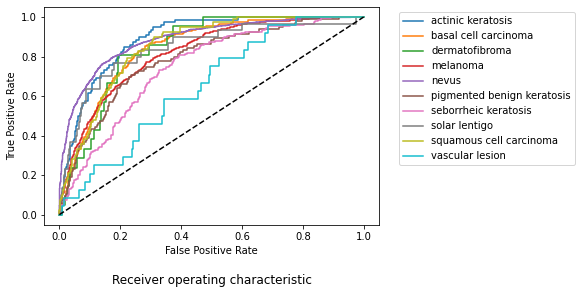

In [16]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

### GradCam

In [17]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

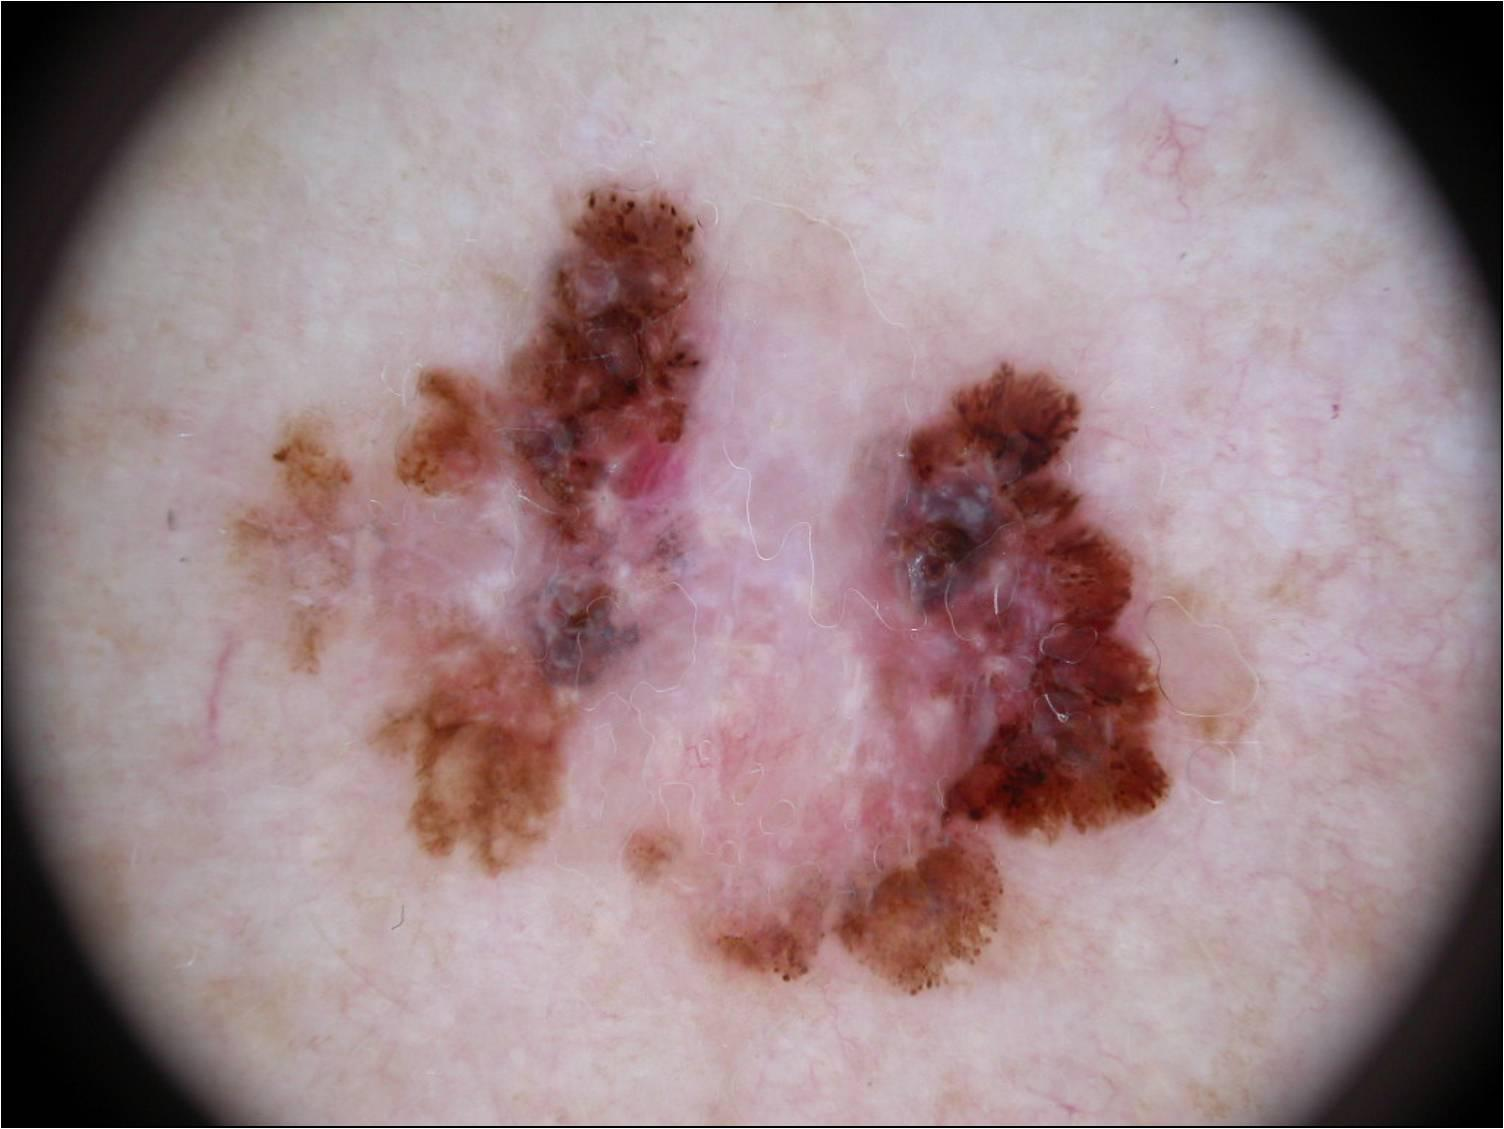

In [18]:
display(Image(melanoma_im_path, width=600))

In [19]:
img_array = tf.keras.applications.xception.preprocess_input(get_img_array(melanoma_im_path, size=(299, 299)))

In [20]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, 'block14_sepconv2')

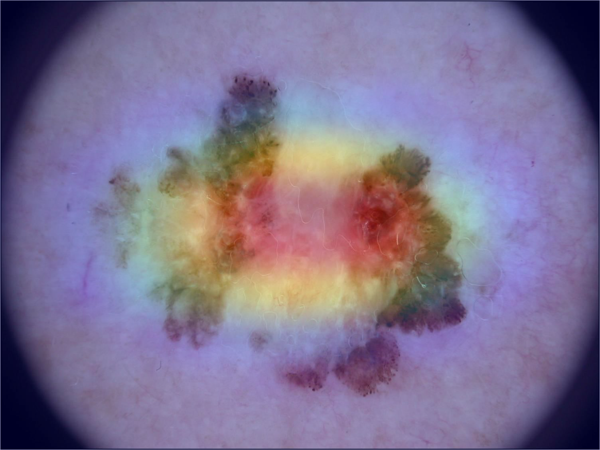

In [21]:
display_gradcam(melanoma_im_path, heatmap)